In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import PIL
import glob
import scipy.io
from sklearn.model_selection import train_test_split
import imageio
from PIL import Image


from vae import VAE, Sampling

In [2]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [3]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [4]:
train_size = 60000
batch_size = 32
test_size = 10000
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [5]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(28 * 28 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((28, 28, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=1, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________________

In [6]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(),run_eagerly=True)
vae.fit(train_dataset, validation_data=test_dataset, epochs=3)

Epoch 1/3
1875/1875 [==============================] - ETA: 0s - loss: 193.6467 - reconstruction_loss: 167.7470 - kl_loss: 6.0740WARNING:tensorflow:AutoGraph could not transform <bound method VAE.test_step of <tensorflow.python.eager.function.TfMethodTarget object at 0x16af8da90>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1875/1875 [==============================] - 96s 51ms/step - loss: 193.6362 - reconstruction_lo

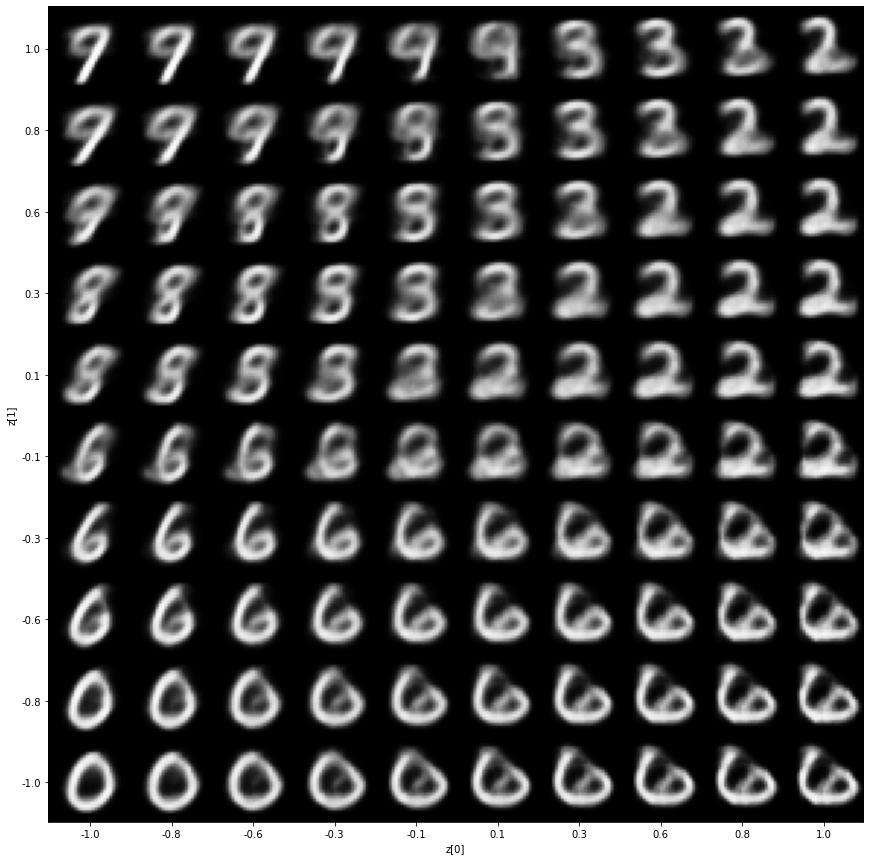

In [10]:
def plot_latent_space(vae, n=10, figsize=15):
    # display a n*n 2D manifold of digits
    scale = 1.0
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.savefig('manifold.png')
    plt.show()

plot_latent_space(vae)

In [12]:
vae.decoder.save('decoder.h5')

In [ ]:
def save_images_from_model(model,n=50):
    images = []
    scale = 1.0
    digit_size = 28
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            formatted = (digit * 255 / np.max(digit)).astype('uint8')
            im = Image.fromarray(formatted)
            im.save('man-images/{}_{}.png'.format(j, i))
#             if j==i:
#                 images.append(digit)
#     imageio.mimsave('manifold.gif', images)
save_images_from_model(vae)